# Customer Classification

In [7]:
!pip install pyqt5

     |████████████████████████████████| 8.3 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 349 kB 58.3 MB/s eta 0:00:01
     |████████████████████████████████| 59.9 MB 60 kB/s s eta 0:00:01     |█████████████████▍              | 32.6 MB 60.0 MB/s eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
spyder 5.1.5 requires pyqt5<5.13, but you have pyqt5 5.15.6 which is incompatible.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

In [10]:
train_df = pd.read_csv('Customer-classification/existing_base_train.csv')
test_df = pd.read_csv('Customer-classification/existing_base_test.csv')

print('Shape train', train_df.shape)
print('\nShape test', test_df.shape)

print('\nRevenue grid count:\n',train_df['Revenue_Grid'].value_counts())
print('\nAny null values ?:', train_df.isnull().values.any())

print(train_df.info())

Shape train (8124, 32)

Shape test (2031, 31)

Revenue grid count:
 2    7264
1     860
Name: Revenue_Grid, dtype: int64

Any null values ?: False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   REF_NO                           8124 non-null   int64  
 1   children                         8124 non-null   object 
 2   age_band                         8124 non-null   object 
 3   status                           8124 non-null   object 
 4   occupation                       8124 non-null   object 
 5   occupation_partner               8124 non-null   object 
 6   home_status                      8124 non-null   object 
 7   family_income                    8124 non-null   object 
 8   self_employed                    8124 non-null   object 
 9   self_employed_partner            8124 non-null   object 
 1

### EDA

In [3]:
profile = train_df.profile_report(title="Customer Classification Profiling - Before Pre-Processing", progress_bar=False, minimal=True)
profile.to_file(output_file="profiling_before_preprocessing.html")
print('Data Pre-Profiling created successfully.')

Data Pre-Profiling created successfully.


### Data Pre-Profiling

1. REF_NO (integer, 8124 distinct values):
    - This feature are row counts.
    
2. post_code (categorical, 8050 distinct values):
    - Having high cardinality, can be removed

3. post_code (categorical, 1937 distinct values):
    - Having high cardinality, can be removed (need to visualize before removing)
    
4. Average_Credit_Card_Transaction (real number):
    - 4989 (61.4%) customers doesn't have credit cards. Hence, their value are zero
    
5. Term deposit:
    - 4587 (56.5%) customers aren't having term deposit.
    
6. Life Insurance:
    - 2454 (30.2%) customers doesn't have life insurance.
    
7. Medical insurance:
    - 4046 (49.8%) customers doesn't have medical insurance.
    
8. Average A/C Balance:
    - 2806 (34.5%) customers average a/c balance is zero.

9. Personal Loan:
    - 5134 (63.2%) customers doesn't have personal loan.
    
10. Investment in Mutal Fund:
    - 2602 (32.0%) customers doesn't have mutual fund.
    
11. Investment in Tax Saving Bond:
    - 5133 (63.2%) customers doesn't have tax saving bond.

12. Home Loan:
    - 5609 (69.0%) customers doesn't have home loan.
    
13. Online Purchase Amount:
    -  5700 (70.2%) customers doesn't do online purchase.
    
14. Investment in Commudity:
    - 825 (10.2%) customers have zero investments.
    
15. Investment in Equity:
    - 915 (11.3%) customers have zero investments.

16. Investment in Derivative:
    - 445 (5.5%) customers have zero investments.

In [12]:
def plot_bar(data, xLabel, yLabel, hv):
    plt.figure(figsize=(10,8))
    if hv == 'h':
        plt.bar(data.index, data.values,data=data)
    else:
        plt.barh(data.index, data.values,data=data)
    plt.xlabel("Children", size=15)
    plt.ylabel("Count", size=15)

<Figure size 432x288 with 0 Axes>

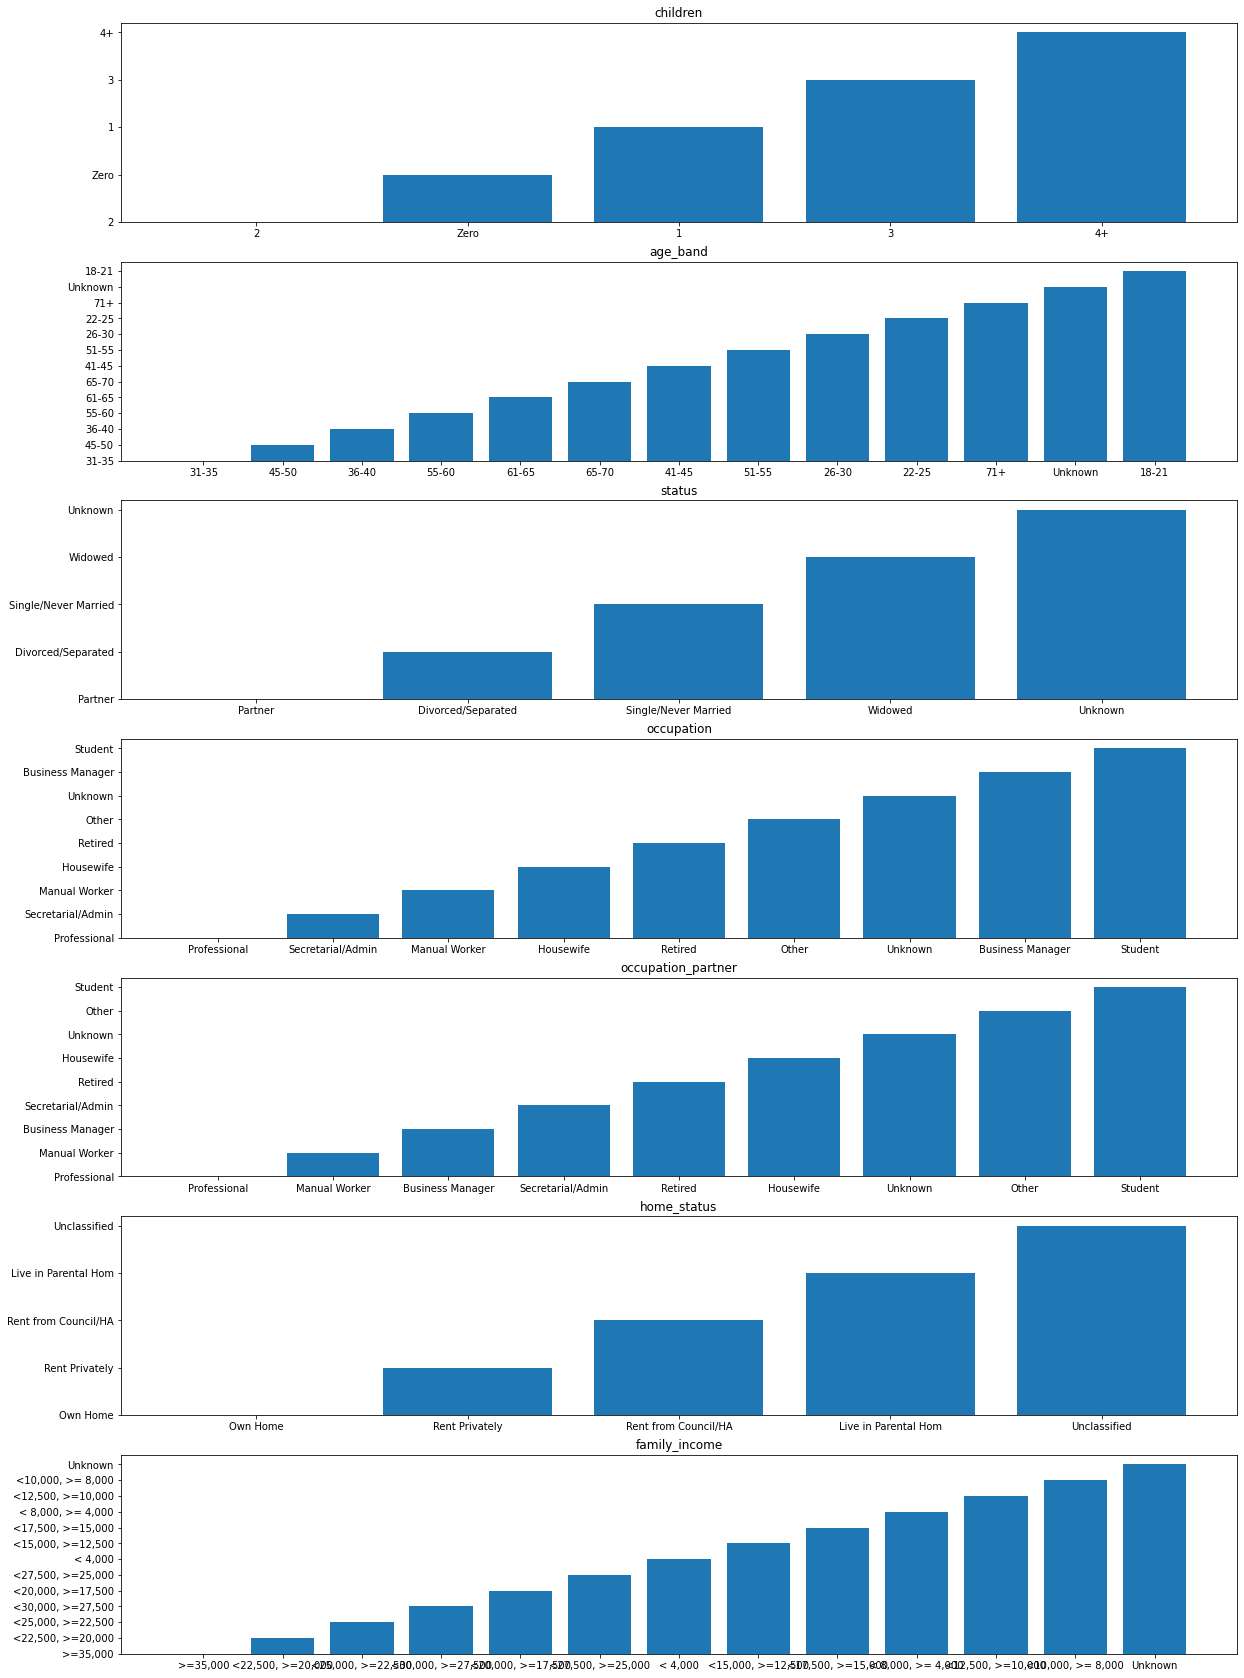

In [13]:
fig = plt.figure()
columns = ['children', 'age_band', 'status', 'occupation', 'occupation_partner', 'home_status', 'family_income']

fig = plt.figure(figsize=(20,30))

for i, j in enumerate(columns):
    data = train_df[j].values
    ax = fig.add_subplot(7,1,i+1)
    ax.bar(data,data)
    ax.set_title(j)
    
plt.show()

<Figure size 432x288 with 0 Axes>

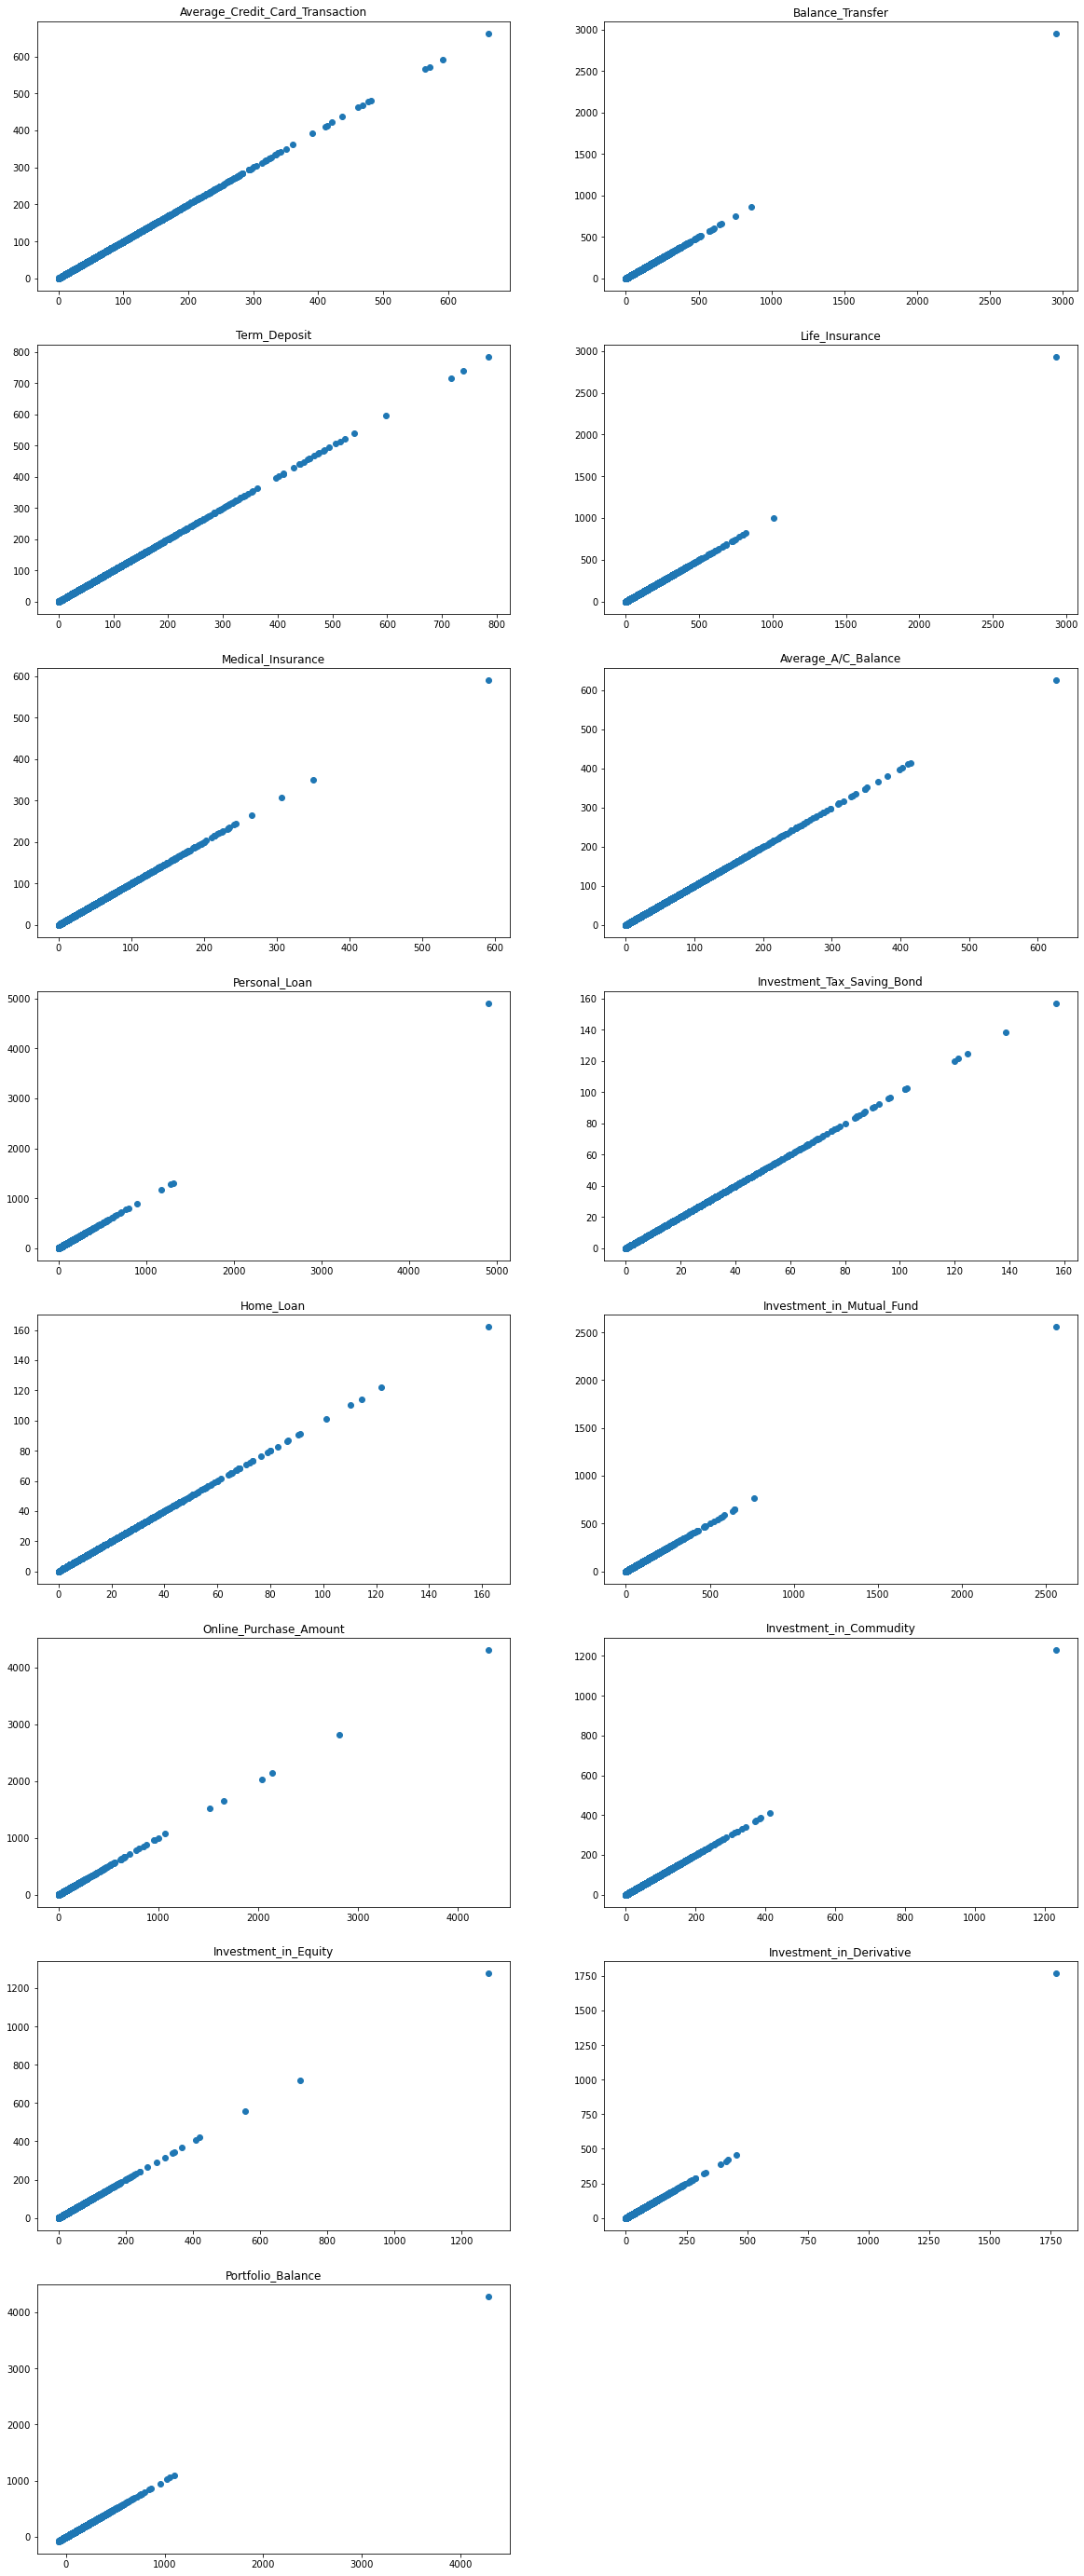

In [14]:
fig = plt.figure()
columns = ['Average_Credit_Card_Transaction', 'Balance_Transfer', 
           'Term_Deposit', 'Life_Insurance', 'Medical_Insurance', 
           'Average_A/C_Balance', 'Personal_Loan', 'Investment_Tax_Saving_Bond', 
           'Home_Loan', 'Investment_in_Mutual_Fund', 'Online_Purchase_Amount', 
           'Investment_in_Commudity', 'Investment_in_Equity', 
           'Investment_in_Derivative', 'Portfolio_Balance']

fig = plt.figure(figsize=(20,50))

for i, j in enumerate(columns):
    data = train_df[j].values
    ax = fig.add_subplot(8,2,i+1)
    ax.scatter(data,data)
    ax.set_title(j)
    
plt.show()

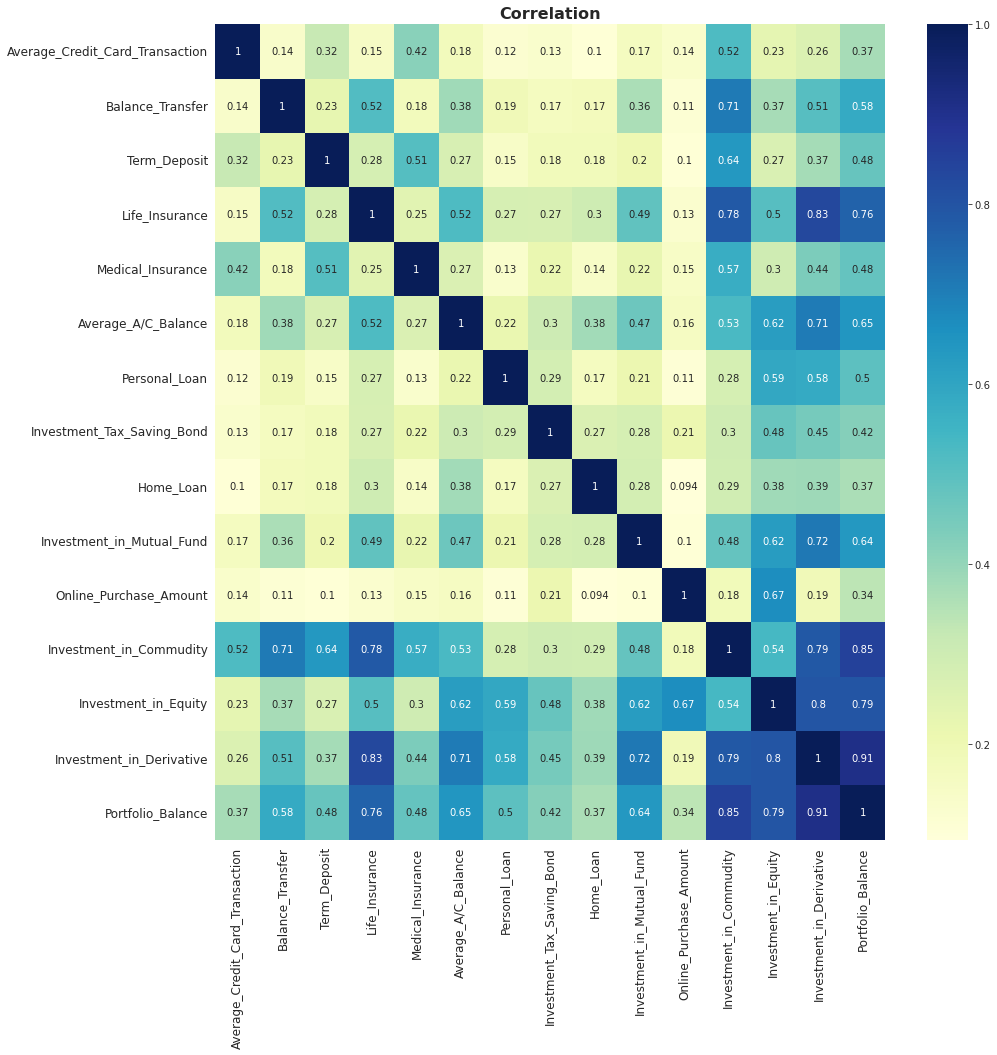

In [15]:
def plot_pre_config(figsize):
    sns.set_style("whitegrid")
    bar, ax = plt.subplots(figsize=figsize)
    return ax

def plot_post_config(title, xlabel, ylabel, fontsize, labelsize):
    ax.tick_params(labelsize=labelsize)
    ax.set_title(title, fontsize=fontsize, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=fontsize, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=fontsize, fontweight='bold')

corr_data = train_df[train_df['Balance_Transfer'] < 2500][columns]
corr_mat = corr_data.corr()
plot_pre_config((15,15))
ax = sns.heatmap(corr_mat, annot=True, cmap='YlGnBu')
plot_post_config('Correlation','','',16, 12)

In [16]:
train_df[train_df['Balance_Transfer'] > 2500][columns]

,Average_Credit_Card_Transaction,Balance_Transfer,Term_Deposit,Life_Insurance,Medical_Insurance,Average_A/C_Balance,Personal_Loan,Investment_Tax_Saving_Bond,Home_Loan,Investment_in_Mutual_Fund,Online_Purchase_Amount,Investment_in_Commudity,Investment_in_Equity,Investment_in_Derivative,Portfolio_Balance
3621,0.0,2951.76,251.33,2930.41,21.96,197.9,4905.93,9.48,0.0,2561.27,0.0,1231.09,1279.1,1771.16,4283.56


In [17]:
# Drop row 3621 and re-index

# Drop column REF_NO, post_code, post_area, year_last_moved, TVarea

# Apply scalling to 
# ['Average_Credit_Card_Transaction', 'Balance_Transfer', 
# 'Term_Deposit', 'Life_Insurance', 'Medical_Insurance', 
# 'Average_A/C_Balance', 'Personal_Loan', 'Investment_Tax_Saving_Bond', 
# 'Home_Loan', 'Investment_in_Mutual_Fund', 'Online_Purchase_Amount', 
# 'Investment_in_Commudity', 'Investment_in_Equity', 
# 'Investment_in_Derivative', 'Portfolio_Balance']

# One-hot encoding to 
# ['children', 'age_band', 'status', 'occupation', 'occupation_partner', 'home_status', 
# 'family_income', 'self_employed', 'self_employed_partner', 'gender', 'region']

# split into train-test 
# Apply --> Logistic Regression, Naive Bayes, Decision Trees, RF, SVM, KNN

In [37]:
def trainTestSplit(isBalance):
    df = train_df.copy()

    # 1. Removing the outlier
    train_df_x = df[train_df['Balance_Transfer'] < 2500]

    # 2. Separating dependent and independent variables
    train_df_y = train_df_x[['Revenue_Grid']]

    # 3. Dropping columns with high cardinality
    train_df_x = train_df_x.drop(['REF_NO','post_code', 'post_area', 'year_last_moved','Revenue_Grid', 'TVarea'], axis=1)

    # 4. Converting categorical variables into integers, and dropping the categorical variables
    encode_columns = ['children', 'age_band', 'status', 'occupation', 'occupation_partner', 'home_status', 
    'family_income', 'self_employed', 'self_employed_partner', 'gender', 'region']
    dummies = pd.get_dummies(train_df_x, columns=encode_columns)
    train_df_x = pd.concat([train_df_x,dummies],axis=1)
    train_df_x = train_df_x.drop(encode_columns, axis=1)
    
    # 5. Balancing the dataset
    if isBalance:
        sm = SMOTE(sampling_strategy='minority', random_state=1)
        oversampled_X, oversampled_Y = sm.fit_resample(train_df_x.values, train_df_y.values)
        train_df_x = pd.DataFrame(oversampled_X, columns=train_df_x.columns)
        train_df_y = pd.DataFrame(oversampled_Y, columns=train_df_y.columns)

    # 6. Performing train-test split
    return train_test_split(train_df_x, train_df_y, test_size=0.25, random_state=42)

In [38]:
X_train, X_test, y_train, y_test = trainTestSplit(True)
print('X: train:test -->', X_train.shape, X_test.shape)
print('y: train:test -->', y_train.shape, y_test.shape)

X: train:test --> (10894, 109) (3632, 109)
y: train:test --> (10894, 1) (3632, 1)


In [39]:
# 7. Performing MinMaxScaller to standardize the data between 0 and 100
scaler = MinMaxScaler()
X_train[columns] = scaler.fit_transform(X_train[columns])
X_test[columns] = scaler.fit_transform(X_test[columns])

In [67]:
# Pre-processing test dataset
y_test_new = test_df.copy()

y_test_new = y_test_new.drop(['REF_NO','post_code', 'post_area', 'year_last_moved', 'TVarea'], 
                            axis=1)

encode_columns = ['children', 'age_band', 'status', 'occupation', 'occupation_partner', 'home_status', 
                    'family_income', 'self_employed', 'self_employed_partner', 'gender', 'region']

dummies = pd.get_dummies(y_test_new, columns=encode_columns)
y_test_new = pd.concat([y_test_new,dummies],axis=1)
y_test_new = y_test_new.drop(encode_columns, axis=1)

y_test_new[columns] = scaler.fit_transform(y_test_new[columns])
y_test_new['region_Channel Islands'] = 0
y_test_new_pop = y_test_new.pop('region_Channel Islands')
y_test_new.insert(96, 'region_Channel Islands', y_test_new_pop)

0 Average_Credit_Card_Transaction
1 Balance_Transfer
2 Term_Deposit
3 Life_Insurance
4 Medical_Insurance
5 Average_A/C_Balance
6 Personal_Loan
7 Investment_in_Mutual_Fund
8 Investment_Tax_Saving_Bond
9 Home_Loan
10 Online_Purchase_Amount
11 Investment_in_Commudity
12 Investment_in_Equity
13 Investment_in_Derivative
14 Portfolio_Balance
15 Average_Credit_Card_Transaction
16 Balance_Transfer
17 Term_Deposit
18 Life_Insurance
19 Medical_Insurance
20 Average_A/C_Balance
21 Personal_Loan
22 Investment_in_Mutual_Fund
23 Investment_Tax_Saving_Bond
24 Home_Loan
25 Online_Purchase_Amount
26 Investment_in_Commudity
27 Investment_in_Equity
28 Investment_in_Derivative
29 Portfolio_Balance
30 children_1
31 children_2
32 children_3
33 children_4+
34 children_Zero
35 age_band_18-21
36 age_band_22-25
37 age_band_26-30
38 age_band_31-35
39 age_band_36-40
40 age_band_41-45
41 age_band_45-50
42 age_band_51-55
43 age_band_55-60
44 age_band_61-65
45 age_band_65-70
46 age_band_71+
47 age_band_Unknown
48 sta

(2031, 109)

In [68]:
# 7. Building the model
# model = GaussianNB().fit(X_train,y_train)
model = LogisticRegression(max_iter=200).fit(X_train, y_train.values.ravel())
pred = model.predict(X_test)
pred2 = model.predict(y_test_new)
print(len(pred))
print(len(pred2))

3632
2031


In [72]:
output = pd.concat([test_df['REF_NO'], pd.DataFrame(pred2, columns=['Revenue_Grid'])],axis=1)
print(output.head())
output.to_csv('submission.csv', index=False, header=False)

   REF_NO  Revenue_Grid
0     697             2
1    7897             1
2    4729             2
3    6914             2
4    2795             2


In [69]:
#8. Evaluating the model

cm = confusion_matrix(y_test, pred)
print('Confusion Matrix: \n\n', cm)

a_score = accuracy_score(y_test, pred)
print('\n\nAccuracy Score:', a_score)

c_report = classification_report(y_test, pred)
print('\n\nClassification Report:\n\n', c_report)

Confusion Matrix: 

 [[1668  164]
 [ 270 1530]]


Accuracy Score: 0.8805066079295154


Classification Report:

               precision    recall  f1-score   support

           1       0.86      0.91      0.88      1832
           2       0.90      0.85      0.88      1800

    accuracy                           0.88      3632
   macro avg       0.88      0.88      0.88      3632
weighted avg       0.88      0.88      0.88      3632

